In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]

import PHELPH


In [2]:
system = PHELPH.PHELPH(kmax=2.5, n_kmax=100)

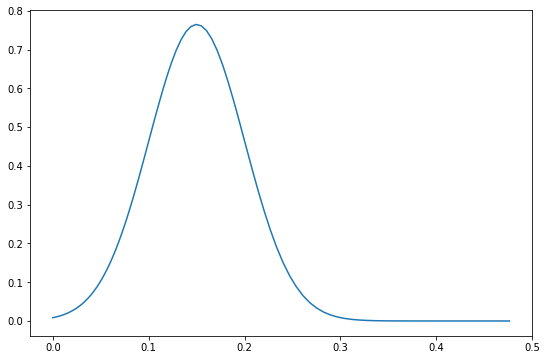

In [3]:
system.T_cryo = 300

inits = system.get_init_cond_gauss(max_pos = 0.15, width = 0.05, density=0.1, I_0=1e-6)

plt.plot(system.E_el_vec,inits[:system.n_kmax])
plt.show()

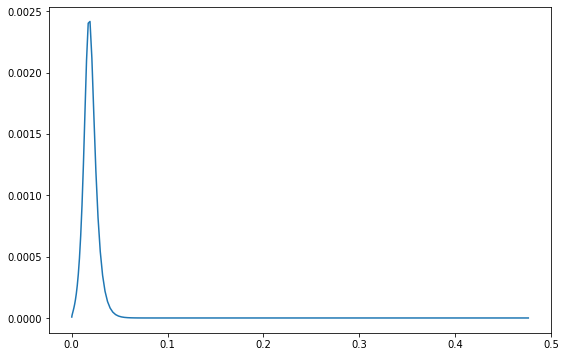

In [4]:
#smooth v2
system.g_photon = 0.04
system.tau_photon = 200
system.E_photon = 0.035
system.linewidth = 0.01

system.setup_laser()

plt.plot(system.E_el_vec,system.I_gain_helper_vec)
plt.show()


# plt.plot(system.E_el_vec,system.lineshape_vec)
# plt.show()

# plt.plot(system.E_el_vec,system.DOS_vec)
# plt.show()


In [5]:
tmax=10000
n_tmax = 1001
t_vec = np.linspace(0,tmax,n_tmax)


system.extI = False
system.extI_pos = 1500
system.extI_max = 0.015
system.extI_width = 400


trajectory = system.get_full_trajectory(inits, tmax=tmax, n_tmax=n_tmax)

el_trajectory = trajectory[:,:system.n_kmax]

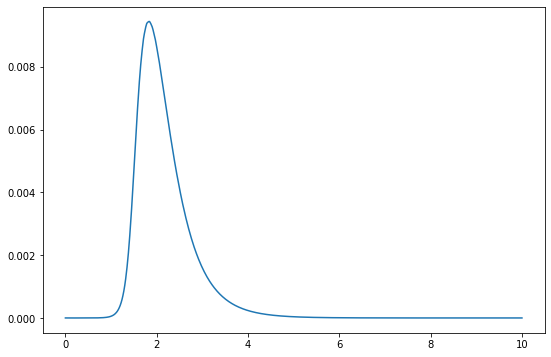

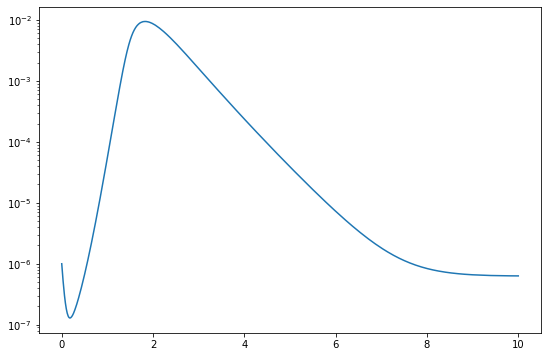

In [6]:
plt.plot(t_vec/1000,trajectory[:,-1])
# plt.plot(t_vec/1000,system.extI_max*np.exp(-((t_vec-system.extI_pos)/system.extI_width)**2/2) )
# plt.xlim(1,3)
plt.show()

plt.semilogy(t_vec/1000,trajectory[:,-1])
plt.show()

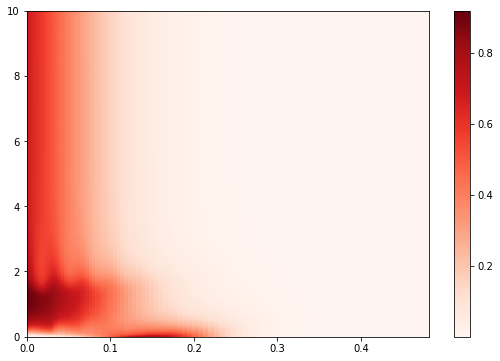

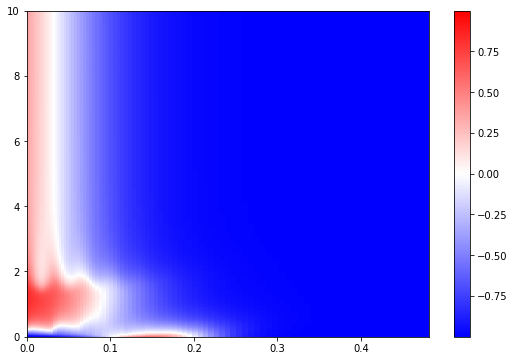

In [7]:
import matplotlib.colors as colors

plt.pcolormesh(system.E_el_vec, t_vec/1000, el_trajectory,cmap='Reds')
plt.colorbar()
plt.show()


inversion = 2*el_trajectory - 1.

plt.pcolormesh(system.E_el_vec, t_vec/1000, inversion,
           cmap='bwr',
           norm=colors.CenteredNorm(vcenter=0.0))
plt.colorbar()
plt.show()

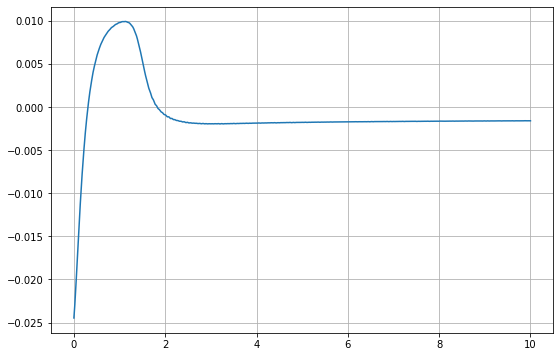

In [8]:
gain = [system.get_net_photon_gain(el_state) for el_state in el_trajectory ]


plt.grid()
plt.plot(t_vec/1000,gain)
plt.show()

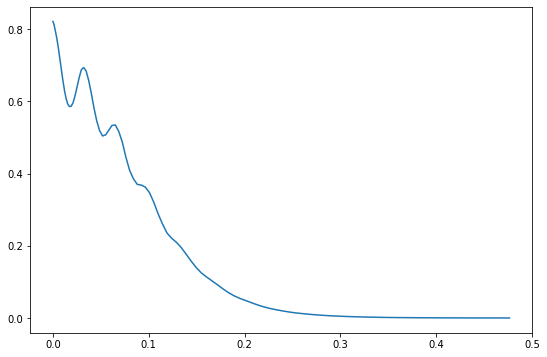

In [11]:
plt.plot(system.E_el_vec,el_trajectory[180])
plt.show()

In [12]:

gain_matrix = np.zeros(el_trajectory.shape)

for row in range(gain_matrix.shape[0]):
    for col in range(gain_matrix.shape[1]):
        system.E_photon = system.E_el_vec[col]
        system.setup_laser()
        
        gain_matrix[row,col] = system.get_net_photon_gain(el_trajectory[row])



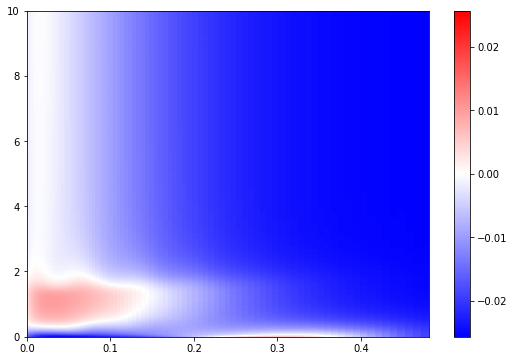

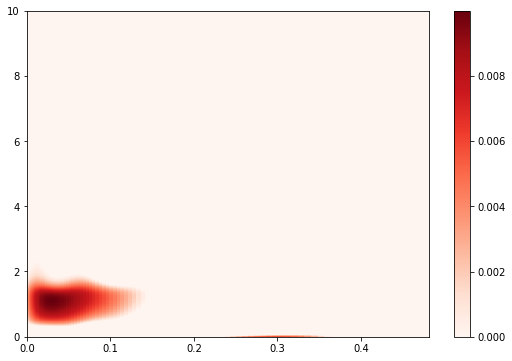

In [13]:
plt.pcolormesh(system.E_el_vec, t_vec/1000, gain_matrix,
               cmap='bwr',
               norm=colors.CenteredNorm(vcenter=0.0))
plt.colorbar()
plt.show()


plt.pcolormesh(system.E_el_vec, t_vec/1000, gain_matrix,
               vmin=0.0,cmap='Reds')
plt.colorbar()
# plt.xlim(0,0.1)
plt.show()

In [16]:
el_scat = np.zeros(el_trajectory.shape)

for row,state in enumerate(trajectory):
    el_scat[row] = system.get_electron_scattering_terms(state) 
    

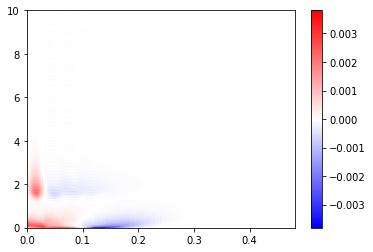

In [17]:
plt.pcolormesh(system.E_el_vec, t_vec/1000, el_scat,
               cmap='bwr',
               norm=colors.CenteredNorm(vcenter=0.0))
plt.colorbar()
plt.show()

In [18]:

trajectory_rk4 = system.integrate(inits, n_steps=1001, dt=5.0, dt_out=10.0)

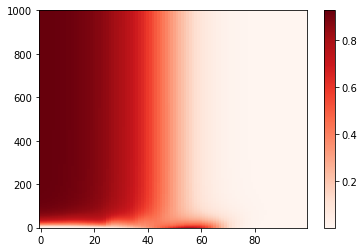

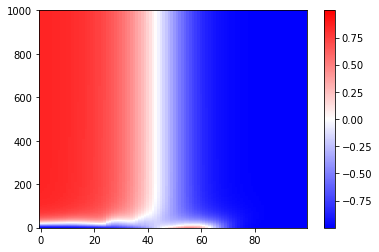

In [19]:
import matplotlib.colors as colors

plt.imshow(trajectory_rk4[:,:system.n_kmax], aspect='auto', interpolation='none', origin='lower',cmap='Reds')
plt.colorbar()
plt.show()


inversion_rk = 2*trajectory_rk4[:,:system.n_kmax] - 1.

plt.imshow(inversion_rk, aspect='auto', interpolation='none', origin='lower',
           cmap='bwr',
           norm=colors.CenteredNorm(vcenter=0.0))
plt.colorbar()
plt.show()

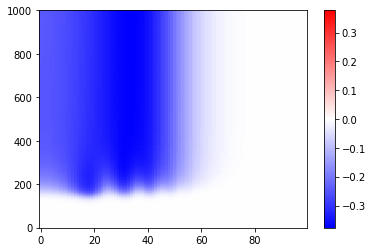

In [20]:
plt.imshow(trajectory[:,:system.n_kmax]-trajectory_rk4[:,:system.n_kmax], aspect='auto', interpolation='none', origin='lower',
           cmap='bwr',
           norm=colors.CenteredNorm(vcenter=0.0))
plt.colorbar()
plt.show()

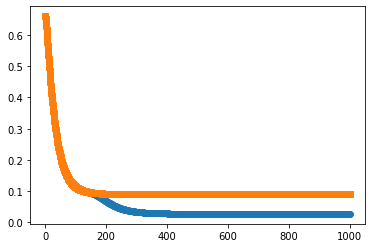

In [21]:
# %matplotlib notebook
%matplotlib inline

plt.plot(trajectory[:,60],marker='o')
plt.plot(trajectory_rk4[:,60],marker='s')
plt.show()

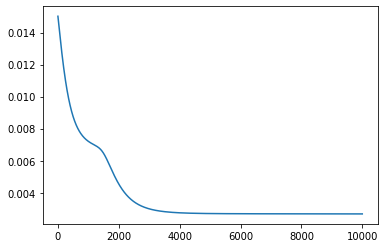

[7.21285315e-02 5.46401846e+02 2.69121076e-03]
[0.005471   0.00162862 0.0005099 ]
tau_rel: 546.4018463601142


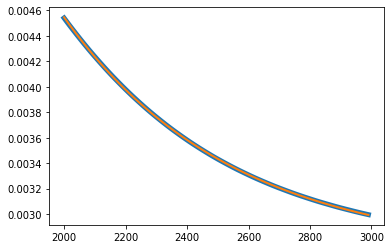

In [34]:
E = np.zeros((el_trajectory.shape[0]))
for k in range(E.size):
    E[k] =  np.sum(el_trajectory[k]*system.DOS_vec*system.E_el_vec)
    
plt.plot(t_vec,E)
plt.show()


ind0 = 200
indd = 100

t_fit = t_vec[ind0:ind0+indd]
E_fit = E[ind0:ind0+indd]

# plt.plot(t_fit,E_fit)
# plt.show()

def fit_exp(t,A,tau,offset):
    return A*np.exp(-t/tau) + offset


from scipy.optimize import curve_fit

popt, pcov = curve_fit(fit_exp, t_fit, E_fit, [0.001,700,0.009])
perr = np.sqrt(np.diag(pcov))

print(popt)
print(perr/popt)

print('tau_rel:',popt[1])


plt.plot(t_fit,E_fit, lw=5)
plt.plot(t_fit, fit_exp(t_fit,*popt), lw=2)
plt.show()